In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
movies = pd.read_csv(
    "movies.dat",
    sep="::",
    engine="python",
    names=["movieId", "title", "genres"]
)

ratings = pd.read_csv(
    "ratings.dat",
    sep="::",
    engine="python",
    names=["userId", "movieId", "rating", "timestamp"]
)

In [3]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,122,5.0,838985046
1,1,185,5.0,838983525
2,1,231,5.0,838983392
3,1,292,5.0,838983421
4,1,316,5.0,838983392


In [4]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
ratings = ratings[["userId", "movieId", "rating"]]

ratings.drop_duplicates(inplace=True)

ratings["userId"] = ratings["userId"].astype(int)
ratings["movieId"] = ratings["movieId"].astype(int)
ratings["rating"] = ratings["rating"].astype(float)

In [6]:
ratings.shape

(10000054, 3)

In [7]:
def train_test_split_userwise(df, test_size=0.2, seed=42):
    np.random.seed(seed)
    train_list = []
    test_list = []

    for user_id, user_data in df.groupby("userId"):
        if len(user_data) < 5:
            train_list.append(user_data)
            continue

        test_count = int(len(user_data) * test_size)
        test_indices = np.random.choice(
            user_data.index,
            size=test_count,
            replace=False
        )

        test_list.append(user_data.loc[test_indices])
        train_list.append(user_data.drop(test_indices))

    train_df = pd.concat(train_list)
    test_df = pd.concat(test_list)

    return train_df, test_df


In [8]:
train_data, test_data = train_test_split_userwise(ratings)

In [9]:
train_data.shape, test_data.shape

((8026731, 3), (1973323, 3))

In [10]:
top_users = train_data['userId'].value_counts().head(2000).index

top_movies = train_data['movieId'].value_counts().head(4000).index

train_sample = train_data[
    train_data['userId'].isin(top_users) &
    train_data['movieId'].isin(top_movies)
]

In [11]:
#  Create user-item matrix
user_item_matrix = train_sample.pivot_table(
    index='userId',
    columns='movieId',
    values='rating'
).fillna(0)

# S Convert to float32 (saves memory)
user_item_matrix = user_item_matrix.astype(np.float32)

In [12]:
R = user_item_matrix.values

print("User-Item matrix shape:", R.shape)
print("Approx memory usage (MB):", R.nbytes / (1024**2))

User-Item matrix shape: (2000, 4000)
Approx memory usage (MB): 30.517578125


In [13]:
# Compute user mean ratings
user_means = R.mean(axis=1).reshape(-1, 1)

# Mean-center
R_centered = R - user_means

print("Mean-centered matrix ready:", R_centered.shape)

Mean-centered matrix ready: (2000, 4000)


In [14]:
# Full SVD (U, Sigma, V^T)
U, sigma, Vt = np.linalg.svd(R_centered, full_matrices=False)

print("Shapes -> U:", U.shape, "Sigma:", sigma.shape, "Vt:", Vt.shape)

Shapes -> U: (2000, 2000) Sigma: (2000,) Vt: (2000, 4000)


In [15]:
k = 50  # latent dimensions
U_k = U[:, :k]
sigma_k = np.diag(sigma[:k])
Vt_k = Vt[:k, :]

In [16]:
# Predicted ratings = U_k * Sigma_k * Vt_k + user mean
R_pred = np.dot(np.dot(U_k, sigma_k), Vt_k) + user_means

# Convert to DataFrame for easy lookup
R_pred_df = pd.DataFrame(
    R_pred,
    index=user_item_matrix.index,
    columns=user_item_matrix.columns
)

print("Predicted ratings matrix ready:", R_pred_df.shape)

Predicted ratings matrix ready: (2000, 4000)


In [17]:
def recommend_svd(user_id, k=10, return_titles=True):
    if user_id not in R_pred_df.index:
        return [] if not return_titles else pd.DataFrame(columns=['title','genres','pred_rating'])

    # Movies already rated by the user (only keep those present in R_pred_df)
    watched = [m for m in train_data[train_data["userId"] == user_id]["movieId"].values
               if m in R_pred_df.columns]

    
    user_ratings = R_pred_df.loc[user_id]

    
    user_ratings = user_ratings.drop(watched, errors='ignore')

    
    top_movies_ids = user_ratings.sort_values(ascending=False).head(k).index.tolist()

    if return_titles:
        top_movies_df = movies[movies['movieId'].isin(top_movies_ids)].copy()
        top_movies_df['pred_rating'] = top_movies_df['movieId'].map(user_ratings)
        top_movies_df = top_movies_df.sort_values(by='pred_rating', ascending=False)
        return top_movies_df[['title', 'genres', 'pred_rating']]

    return top_movies_ids

In [18]:
def display_recommendations(top_df):
    
    if top_df.empty:
        print("No recommendations available.")
        return
    
    # Reset index and keep movieId as a column
    top_df_clean = top_df.reset_index(drop=False)  
    top_df_clean = top_df_clean.rename(columns={
        'index': 'MovieID',        
        'title': 'Title',
        'genres': 'Genres',
        'pred_rating': 'Predicted Rating'
    })
    
    
    top_df_clean = top_df_clean[['MovieID','Title', 'Genres', 'Predicted Rating']]
    
    
    top_df_clean.index = np.arange(1, len(top_df_clean) + 1)
    
    print(top_df_clean)



user_id = R_pred_df.index[1000]
print("Using user_id:", user_id)

top10 = recommend_svd(user_id, k=10)
display_recommendations(top10)

Using user_id: 35223
    MovieID                                              Title  \
1      6427  Pirates of the Caribbean: The Curse of the Bla...   
2      1994                            Jungle Book, The (1967)   
3       893                            Some Like It Hot (1959)   
4      1113             Monty Python and the Holy Grail (1975)   
5       580                                  Home Alone (1990)   
6      7247       Eternal Sunshine of the Spotless Mind (2004)   
7      1564                           L.A. Confidential (1997)   
8      5349                             Minority Report (2002)   
9      2677                            Sixth Sense, The (1999)   
10     9127                               Batman Begins (2005)   

                                  Genres  Predicted Rating  
1        Action|Adventure|Comedy|Fantasy          4.413373  
2      Animation|Children|Comedy|Musical          3.985177  
3                           Comedy|Crime          3.956860  
4       

In [19]:
def precision_recall_f1_at_k_svd(user_id, k=12, threshold=4.0):
    
    recommended = recommend_svd(user_id, k=k, return_titles=False)
    
    if len(recommended) == 0:
        return None, None, None
    
    # Relevant movies from test set (rating >= threshold)
    relevant = test_data[
        (test_data["userId"] == user_id) & 
        (test_data["rating"] >= threshold)
    ]["movieId"].values
    
    if len(relevant) == 0:
        return None, None, None
    
    tp = len(set(recommended) & set(relevant))  
    
    precision = tp / k
    recall = tp / len(relevant)
    f1 = 0 if precision + recall == 0 else 2 * precision * recall / (precision + recall)
    
    return precision, recall, f1

In [20]:
np.random.seed(42)

# Only users with at least 5 ratings in test set
eligible_users = test_data['userId'].value_counts()
eligible_users = eligible_users[eligible_users >= 5].index

sample_users = np.random.choice(
    eligible_users,
    size=250,  # adjust sample size for speed
    replace=False
)

In [21]:
K = 12

precisions, recalls, f1s = [], [], []

for user_id in sample_users:
    p, r, f1 = precision_recall_f1_at_k_svd(user_id, k=K)
    
    if p is not None:
        precisions.append(p)
        recalls.append(r)
        f1s.append(f1)

print("Average Precision@K:", np.mean(precisions))
print("Average Recall@K:", np.mean(recalls))
print("Average F1@K:", np.mean(f1s))

Average Precision@K: 0.7638888888888888
Average Recall@K: 0.11513760563008169
Average F1@K: 0.19651437510085182


In [22]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score
import matplotlib.pyplot as plt

threshold = 4.0  # rating threshold for relevance

y_true = [] 
y_scores = []  

for user_id in sample_users:
    if user_id not in R_pred_df.index:
        continue
    
    # Movies in test set for this user
    test_movies = test_data[test_data['userId'] == user_id]
    
    for _, row in test_movies.iterrows():
        movie_id = row['movieId']
        rating = row['rating']
        
        # Skip movies not in prediction matrix
        if movie_id not in R_pred_df.columns:
            continue
        
        y_true.append(1 if rating >= threshold else 0)
        y_scores.append(R_pred_df.loc[user_id, movie_id])

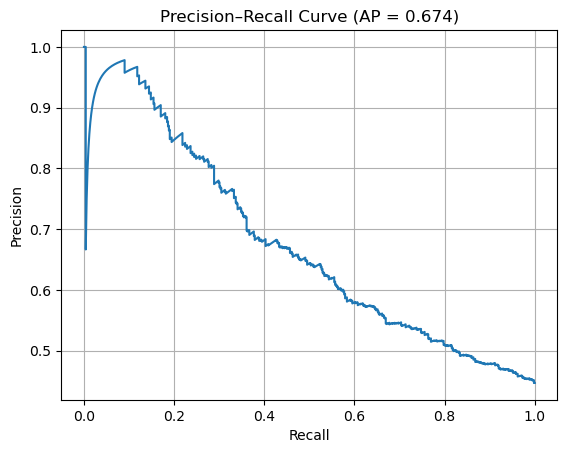

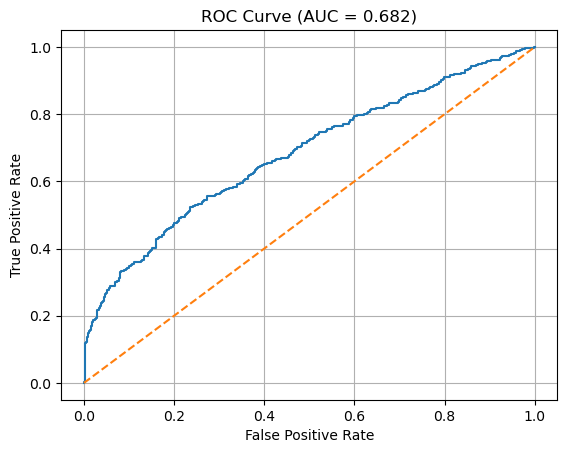

In [23]:
precision, recall, _ = precision_recall_curve(y_true, y_scores)
ap_score = average_precision_score(y_true, y_scores)

plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision–Recall Curve (AP = {ap_score:.3f})")
plt.grid(True)
plt.show()


fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve (AUC = {roc_auc:.3f})")
plt.grid(True)
plt.show()


In [24]:
# Evaluation Metrics for SVD at different Top-K

def precision_recall_f1_at_k_svd(user_id, k=10):
    
    recommended = recommend_svd(user_id, k=k, return_titles=False)
    
    if len(recommended) == 0:
        return None, None, None
    
    # Relevant movies in test set (rated >= 4)
    relevant = test_data[
        (test_data["userId"] == user_id) &
        (test_data["rating"] >= 4)
    ]["movieId"].values
    
    if len(relevant) == 0:
        return None, None, None
    
    # True positives
    tp = len(set(recommended) & set(relevant))
    
    precision = tp / k
    recall = tp / len(relevant)
    f1 = 0 if precision + recall == 0 else 2 * precision * recall / (precision + recall)
    
    return precision, recall, f1


np.random.seed(42)
user_test_counts = test_data["userId"].value_counts()
eligible_users = user_test_counts[user_test_counts >= 5].index  # users with >=5 test ratings
sample_users = np.random.choice(eligible_users, size=250, replace=False)

top_k_values = [10, 20, 50]
results = {}

for k in top_k_values:
    precisions, recalls, f1s = [], [], []
    for user_id in sample_users:
        p, r, f1 = precision_recall_f1_at_k_svd(user_id, k=k)
        if p is not None:
            precisions.append(p)
            recalls.append(r)
            f1s.append(f1)
    results[k] = {
        "Precision": np.mean(precisions),
        "Recall": np.mean(recalls),
        "F1": np.mean(f1s)
    }

# Display nicely

results_df = pd.DataFrame(results).T
results_df.index.name = "Top-K"
results_df = results_df.round(3)
print("SVD Evaluation Metrics at different Top-K:")
print(results_df)

SVD Evaluation Metrics at different Top-K:
       Precision  Recall     F1
Top-K                          
10         0.750   0.096  0.167
20         0.708   0.178  0.277
50         0.503   0.311  0.368


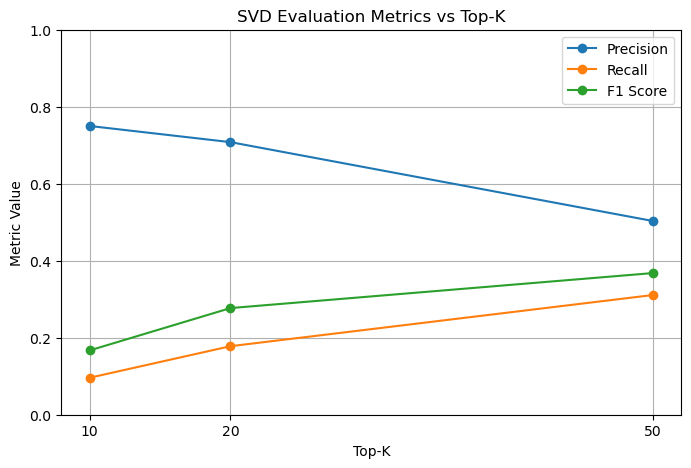

In [25]:
# Line chart for metrics at different Top-K
plt.figure(figsize=(8,5))
plt.plot(results_df.index, results_df['Precision'], marker='o', label='Precision')
plt.plot(results_df.index, results_df['Recall'], marker='o', label='Recall')
plt.plot(results_df.index, results_df['F1'], marker='o', label='F1 Score')
plt.title('SVD Evaluation Metrics vs Top-K')
plt.xlabel('Top-K')
plt.ylabel('Metric Value')
plt.xticks(results_df.index)
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.show()


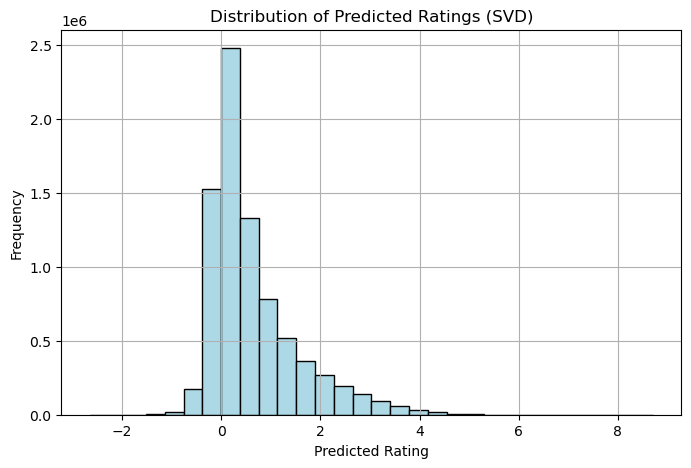

In [26]:
# Flatten all predicted ratings
all_pred_ratings = R_pred_df.values.flatten()

plt.figure(figsize=(8,5))
plt.hist(all_pred_ratings, bins=30, color='lightblue', edgecolor='black')
plt.title('Distribution of Predicted Ratings (SVD)')
plt.xlabel('Predicted Rating')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


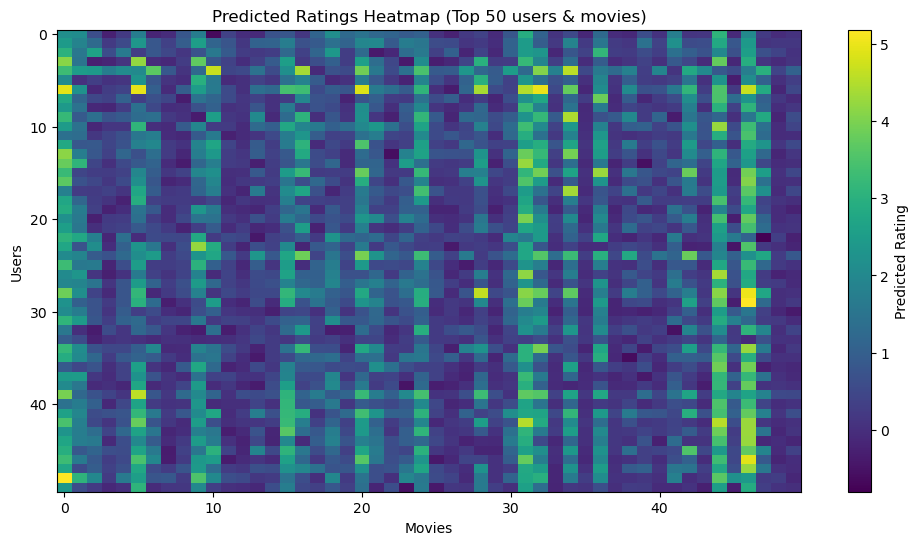

In [27]:
plt.figure(figsize=(12,6))
plt.imshow(R_pred_df.iloc[:50, :50], aspect='auto', cmap='viridis')
plt.colorbar(label='Predicted Rating')
plt.title('Predicted Ratings Heatmap (Top 50 users & movies)')
plt.xlabel('Movies')
plt.ylabel('Users')
plt.show()
